In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
from DA_PoC.filters.EnKF import EnKF
from DA_PoC.dynamicalsystems.lorenz93 import Lorenz93Model
rng = np.random.default_rng(seed=18)

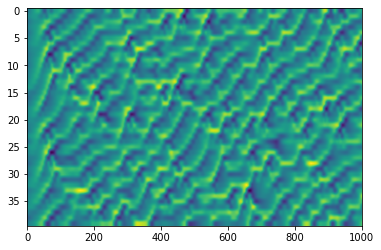

In [50]:

# Set class variable
state_dimension = 40
Lorenz93Model.dim = state_dimension
lorenz40 = Lorenz93Model()
x0 = np.random.normal(0, 1, lorenz40.dim)
lorenz40.set_initial_state(0, x0)
lorenz40.forward(1000)
plt.imshow(lorenz40.state_vector, aspect="auto")
plt.show()

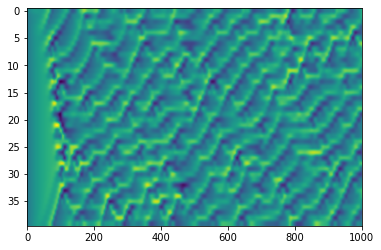

In [51]:
truth = Lorenz93Model()
x0 = np.zeros(state_dimension)
x0[0] = 1
truth.set_initial_state(-1000 * truth.dt, x0)
truth.forward(1000)
plt.imshow(truth.state_vector, aspect="auto")
plt.show()

In [52]:
def create_projector(n, m, indices):
    H = np.zeros((m, n))
    for i in indices:
        H[i, i] = 1
    return H

In [53]:
period_assim = 2
sigobs = 2
Nensemble = 400
dim_observations = 20#state_dimension 
H = create_projector(state_dimension, dim_observations, np.arange(dim_observations))
R = sigobs * np.eye(dim_observations)
inflation_factor=1.2

In [54]:
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + rng.standard_normal(size=state_dimension) * sigobs
    return truth.t[-1], y

In [55]:
enkf = EnKF(state_dimension, Nensemble, R, inflation_factor, rng=rng)
enkf.set_forwardmodel(lambda x: Lorenz93Model.integrate(0, x, period_assim,)[1][:, -1])
enkf.H = H
siginit = 0.2
initial_state = truth.state_vector[:, -1]
covariance = siginit * np.eye(state_dimension)
enkf.generate_ensemble(mean=initial_state, cov=covariance, rng=rng)

In [56]:
Nsteps = 1000
dEnKF = enkf.run(Nsteps, generate_observations)
# print(f"Xf: {enkf.normalised_anomalies().shape=}")
# print(f"Yf: {enkf.observation_anomalies().shape=}")
# T, T2 = enkf.compute_transform()
# print(f"T : {T.shape=}")

  0%|          | 0/1000 [00:00<?, ?it/s]

/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/dynamicalsystems/lorenz93.py:25: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i + 1) % cls.dim] - x[i - 2]) * x[i - 1] - x[i] + 8
/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/dynamicalsystems/lorenz93.py:25: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i + 1) % cls.dim] - x[i - 2]) * x[i - 1] - x[i] + 8
/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/solvers/solvers.py:24: RuntimeWarning: invalid value encountered in add
  return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/solvers/solvers.py:21: RuntimeWarning: invalid value encountered in add
  k2 = f(t + dt / 2, x + k1 * dt / 2.0, *args)
/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/solvers/solvers.py:24: RuntimeWarning: overflow encountered in multiply
  return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
/mnt/c/Users/a846735/DA_sandbox/.venvDA/lib/python3.8/site

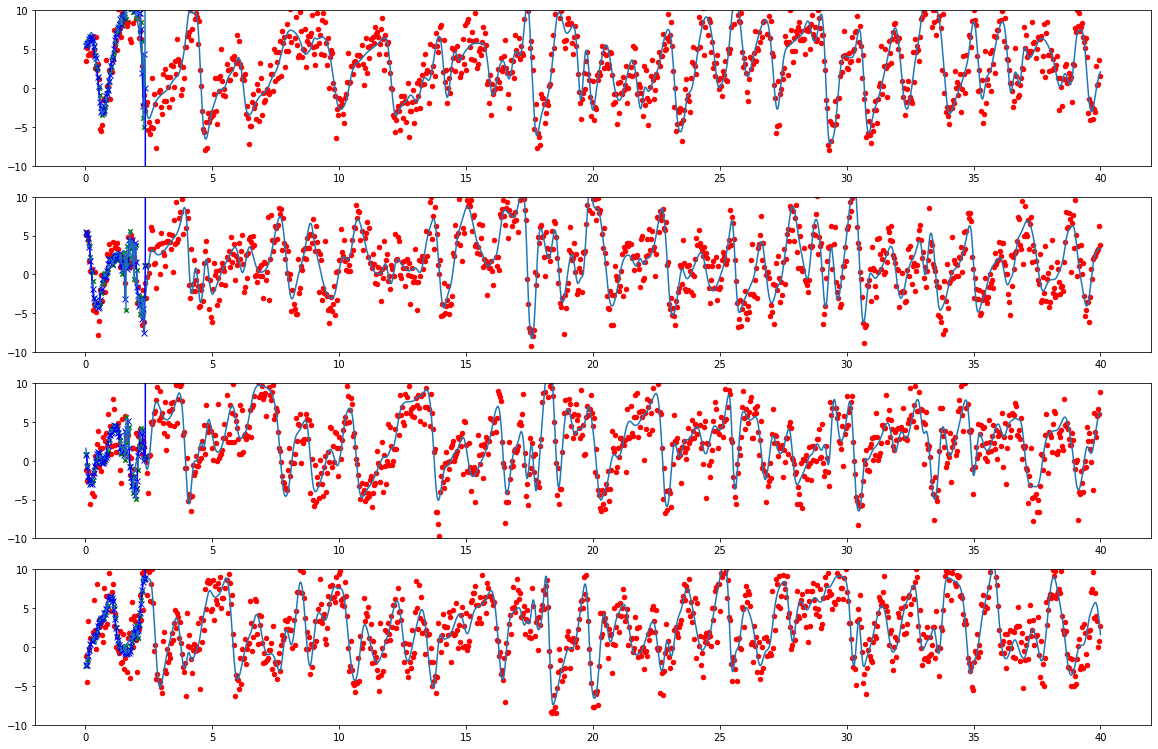

In [57]:
obs_ = np.array(dEnKF["observations"])
xf = np.asarray(dEnKF['ensemble_f'])
xfbar = xf.mean(2)
xa = np.asarray(dEnKF['ensemble_a'])
xabar= xa.mean(2)
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(6, 1, i + 1)
    plt.plot(truth.t[1001:], truth.state_vector[i, 1001:])
    plt.scatter(dEnKF["time"], obs_[:, i], marker="o", c="red", s=20)
    plt.scatter(dEnKF["time"], xfbar[:, i], marker="x", color="green", s=20)
    plt.plot(dEnKF["time"], xabar[:, i], "x-", color="blue")
    plt.vlines(dEnKF["time"], xfbar[:, i], xabar[:, i])
    plt.ylim([-10, 10])
plt.show()

/mnt/c/Users/a846735/DA_sandbox/.venvDA/lib/python3.8/site-packages/numpy/core/_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/mnt/c/Users/a846735/DA_sandbox/.venvDA/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


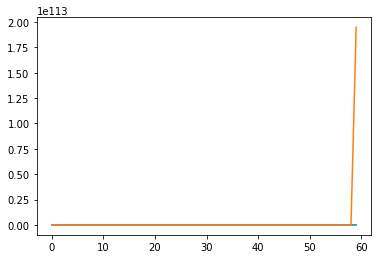

In [58]:
xa_var = xa.var(2)
xf_var = xf.var(2)
plt.plot(xa_var[:, 0])
plt.plot(xf_var[:, 0])

In [59]:
np.isclose(xfbar,xabar).all()

False

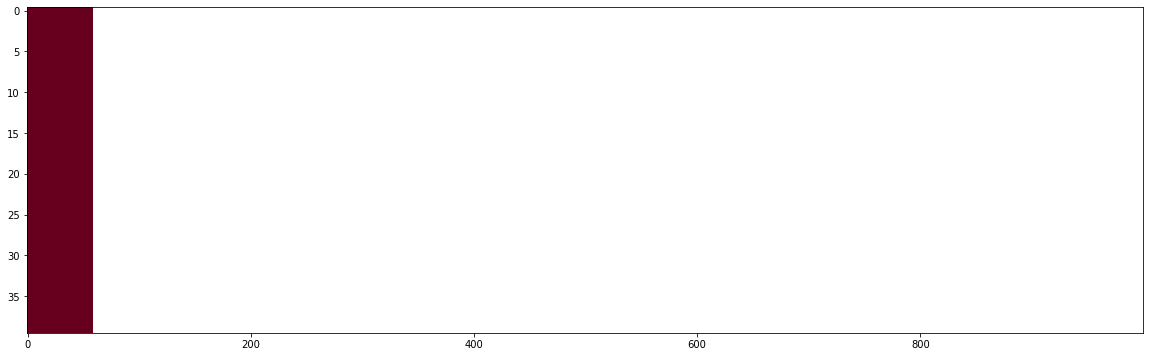

In [60]:
analysis_error = truth.state_vector[:, 1001::period_assim] - np.real(xabar.T)
mi, ma = analysis_error.min(), analysis_error.max()
lim = max(np.abs(mi), np.abs(ma))
plt.figure(figsize=(20, 6))
plt.imshow(analysis_error, vmin=-lim, vmax=lim, cmap='RdBu', aspect='auto')